NS - Schiphol Case

Outline:

0) Imports & Data Upload
1) Train Disruptions
2) Train Timetable & Flights


## 0. Imports & Data Upload

####################################################################################################

### 0.1 Import packages

####################################################################################################

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from sklearn.preprocessing import LabelEncoder

/Users/robbertdriehuijs/Documents/VSCode/Thesis/Thesis_virtual_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


####################################################################################################

### 0.2 Upload data

####################################################################################################

In [2]:
# Train timetable
df = pd.read_csv('Schiphol_GTFS_jul_sep_2021.csv')

# Train Disruptions
df_disruption = pd.read_csv('Treinstoringen jul-sep 2021.csv')

# Flight Timetable
df_flights = pd.read_csv('Schiphol departures and arrivals jul-sep 2021.csv')

## 1. Train Disruptions

####################################################################################################

### 1.1 Preprocessing
* Clean observations (separate obs, correct data type, remove duplicates)
* Introduce new variable: time delay 
* Basic statistics: longest delays, line with longest delays, line with most delays
* Schiphol statistics: total delays, line with most delays

####################################################################################################

In [3]:
# Split disruptions reported together into multiple observations 
df_disruption['lijn'] = df_disruption['lijn'].str.split(';')
df_disruption = df_disruption.explode('lijn')

In [4]:
# Convert the time strings to timedelta objects
df_disruption['tijd_tot'] = pd.to_timedelta(df_disruption['tijd_tot'] + ':00')
df_disruption['tijd_van'] = pd.to_timedelta(df_disruption['tijd_van'] + ':00')
df_disruption['datum'] = pd.to_datetime(df_disruption['datum'])

In [5]:
# Calculate the difference between - start and end of disruption -  and convert the difference into minutes
df_disruption['Disruption Time (Minutes)'] = (df_disruption['tijd_tot'] - df_disruption['tijd_van']).dt.total_seconds() / 60

# Handle exceptions: in case delay lasts until next day
df_disruption['Disruption Time (Minutes)'] = df_disruption['Disruption Time (Minutes)'].apply(lambda x: x + 1440 if x < 0 else x) # Add 24 hours (1440 min) after midnight

In [6]:
# Remove duplicates (23 removed: 1609 to 1586 obs)
df_disruption = df_disruption.drop_duplicates(subset=['lijn', 'type', 'tijd_van', 'tijd_tot', 'datum'], keep='first')

In [7]:
# Display longest delays
df_disruption_long = df_disruption.copy().sort_values('Disruption Time (Minutes)', ascending=False)
df_disruption_long.head(5)

,Unnamed: 0,lijn,type,tijd_van,tijd_tot,datum,Disruption Time (Minutes)
1120,1120,Sittard-Maastricht,wateroverlast,0 days 16:52:00,0 days 16:29:00,2021-07-15,1417.0
629,629,Heerlen-Aachen Hbf,acties in het buitenland,0 days 03:17:00,0 days 02:21:00,2021-08-23,1384.0
1352,1352,Sittard-Maastricht,herstelwerkzaamheden,0 days 19:51:00,0 days 18:30:00,2021-06-29,1359.0
1353,1353,Heerlen-Aachen Hbf,herstelwerkzaamheden,0 days 19:29:00,0 days 17:56:00,2021-06-29,1347.0
1090,1090,Eindhoven-Heerlen,wateroverlast,0 days 16:15:00,0 days 13:58:00,2021-07-17,1303.0


In [8]:
# Display line with longest delays
df_disruption_longest = df_disruption.copy().groupby('lijn').sum('Disruption Time (Minutes)').reset_index().sort_values(by='Disruption Time (Minutes)', ascending=False)
df_disruption_longest.head(5)

,lijn,Unnamed: 0,Disruption Time (Minutes)
152,Haarlem-Zandvoort,10555,6323.0
154,Heerlen-Aachen Hbf,9292,5622.0
157,Hengelo-Bielefeld,12638,4542.0
200,Sittard-Maastricht,7747,3694.0
165,Leeuwarden-Harlingen Haven,10991,3154.0


In [9]:
# Display line with most delays
df_disruption_count = df_disruption.copy().groupby('lijn').size().sort_values(ascending=False)
df_disruption_count = df_disruption_count.to_frame().reset_index()
df_disruption_count.columns = ['lijn', 'count']
df_disruption_count.head(30)

,lijn,count
0,Rotterdam-Breda (HSL),42
1,Arnhem-Nijmegen,30
2,Leiden-Den Haag C,29
3,Amsterdam-Utrecht,29
4,Dordrecht-Roosendaal,27
5,Eindhoven-Venlo,26
6,Utrecht-Amersfoort,24
7,Amsterdam-Haarlem,24
8,Schiphol-Rotterdam (HSL),23
9,Amersfoort-Zwolle,22


In [10]:
# Filter delays involving Schiphol Airport
df_disruption_count['lijn'] = df_disruption_count['lijn'].astype(str)
df_disruption_count_schiphol = df_disruption_count.copy().loc[df_disruption_count['lijn'].str.contains('Schiphol')]

# Display total numbers of delays involving Schiphol Airport
total_sum = df_disruption_count_schiphol['count'].sum()
print(f'Aantal verstoringen rondom Schiphol: {total_sum}')

# Display lines with most delays around Schiphol Airport
df_disruption_count_schiphol_ = df_disruption_count_schiphol.copy().groupby('lijn').size().sort_values(ascending=False)
df_disruption_count_schiphol.columns = ['lijn', 'count']

print(" ")
print("Lines with most delays around Schiphol Airport: ")
df_disruption_count_schiphol.head(10)

Aantal verstoringen rondom Schiphol: 136
 
Lines with most delays around Schiphol Airport: 


,lijn,count
8,Schiphol-Rotterdam (HSL),23
14,Amsterdam-Schiphol-Rotterdam (HSL),20
42,Schiphol-Leiden,12
56,Hoofddorp-Schiphol-Hilversum,10
62,Schiphol-Amersfoort,9
74,Schiphol Airport,8
75,Hoofddorp-Schiphol-Hilversum,8
77,Amsterdam-Schiphol,7
91,Schiphol-Utrecht,6
103,Amsterdam-Schiphol-Leiden,5


####################################################################################################

### 1.2 Distribution of type of delays
* General distribution of disruptions
* Schiphol distribution of disruptions

####################################################################################################

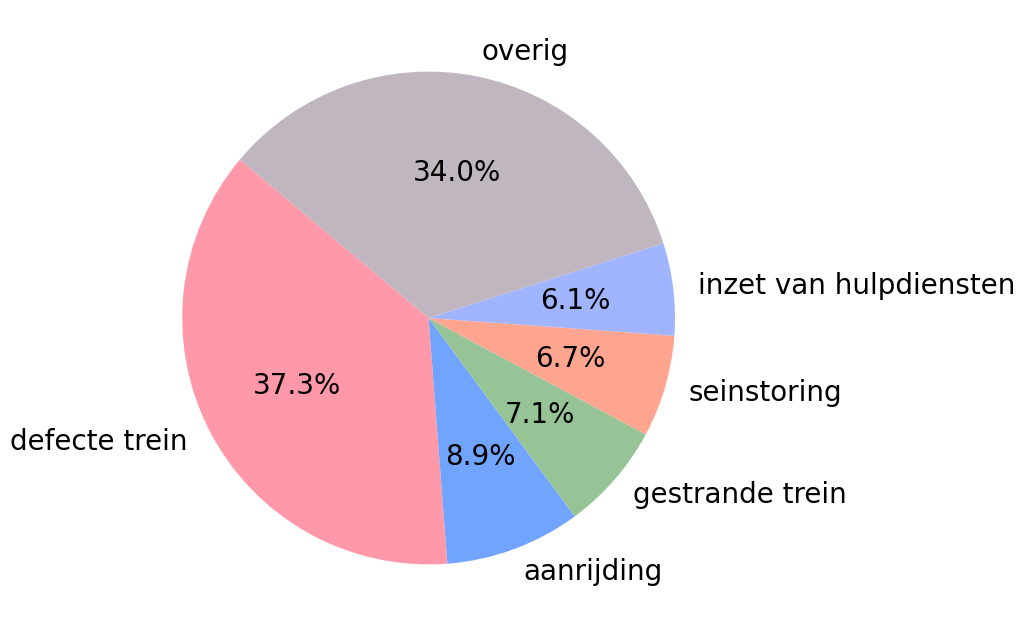

In [11]:
# Only display disruption types above 5%
def custom_autopct(pct):
    if pct > 5:
        return f'{pct:.1f}%'
    else:
        return ''

# Preprocess the data to combine categories with less than 5% into a 'overig' group
df_disruption_counts = df_disruption['type'].value_counts()

# Calculate the percentage of each type of disruption
total = df_disruption_counts.sum()
threshold = 0.05 * total  # 5% threshold

# Split the data into 'overig' and main categories
df_main = df_disruption_counts[df_disruption_counts >= threshold]
df_other = df_disruption_counts[df_disruption_counts < threshold]

# Combine the 'overig' category
df_combined = df_main.copy()
df_combined['overig'] = df_other.sum()

plt.figure(figsize=(14,8))
# Plot the pie chart using the counts
#colors = ['#FF5500', '#008000', '#0055FF', '#FF8000', '#800080', '#55A4FF']
colors = ['#FF99AA', '#70A4FF', '#96C496', '#FFA58F', '#A0B4FF', '#C0B6C0']
df_combined.plot.pie(autopct=custom_autopct, startangle=140, colors=colors, textprops={'fontsize': 20})

# Add title
#plt.title('Overzicht van Verstoringstypen (juni-oktober 2021).')

plt.ylabel('')  
#plt.legend(bbox_to_anchor=(0.85, -0.1))
plt.savefig('Pie_chart')
plt.show()


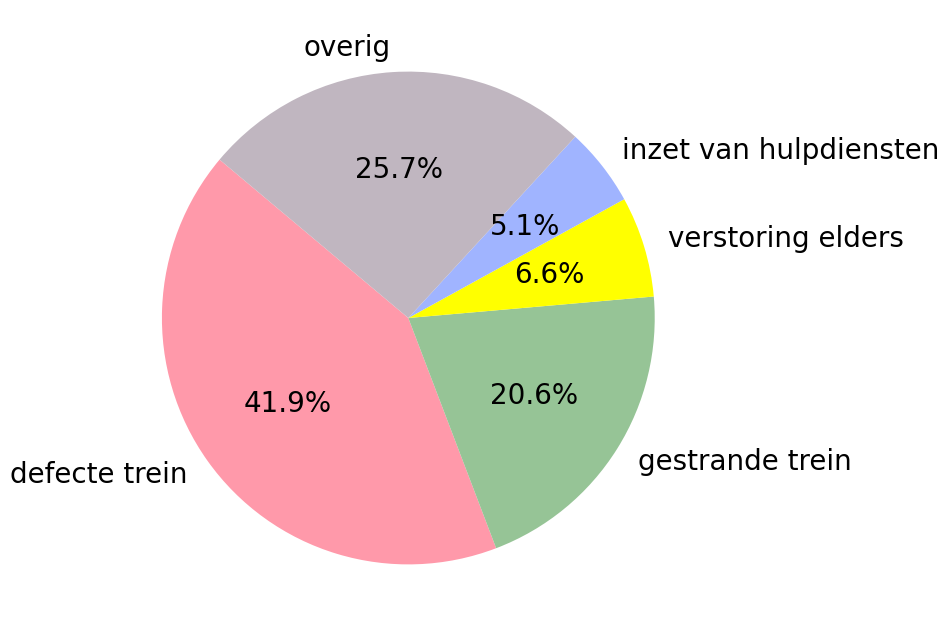

In [12]:
# Display delays involving Schiphol Airport
df_disruption['lijn'] = df_disruption.copy()['lijn'].astype(str)
df_disruption_schiphol = df_disruption.copy().loc[df_disruption['lijn'].str.contains('Schiphol')]

# Preprocess the data to combine categories with less than 5% into a 'overig' group
df_disruption_counts = df_disruption_schiphol['type'].value_counts()

# Calculate the percentage of each type
total = df_disruption_counts.sum()
threshold = 0.05 * total  

# Split the data into 'overig' and main categories
df_main = df_disruption_counts[df_disruption_counts >= threshold]
df_other = df_disruption_counts[df_disruption_counts < threshold]

# Combine the 'overig' category
df_combined = df_main.copy()
df_combined['overig'] = df_other.sum()

plt.figure(figsize=(14,8))
# Plot the pie chart using the counts
#colors = ['#FF5500', '#008000', '#0055FF', '#FF8000', '#800080', '#55A4FF']
colors = ['#FF99AA','#96C496', '#FFFF00','#A0B4FF', '#C0B6C0']
df_combined.plot.pie(autopct=custom_autopct, startangle=140, colors=colors, textprops={'fontsize': 20})

# Add title
#plt.title('Overzicht van Verstoringstypen (juni-oktober 2021).')

plt.ylabel('')  
#plt.legend(bbox_to_anchor=(0.85, -0.1))
plt.savefig('Pie_chart_schiphol')
plt.show()


####################################################################################################

### 1.3 Distribution of disruptions around Schiphol
* Week
* Day
* Hour

####################################################################################################

#### Weekly distribution of disruptions

In [13]:
# Groups disruptions by weeks
weekly_summary = df_disruption_schiphol.groupby(pd.Grouper(key='datum', freq='W-MON')).agg(
    counts=('Disruption Time (Minutes)', 'size'),
    total_disruption_time=('Disruption Time (Minutes)', 'sum')).reset_index()

# Transform delays from minutes to hours
weekly_summary['total_disruption_time'] = weekly_summary['total_disruption_time'] / 60


/var/folders/sh/90yjgzpn6435lg4k792260jw0000gn/T/ipykernel_44447/3569624232.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(weekly_summary['datum'].dt.strftime('%Y-%m-%d'), rotation=45, ha='right', fontsize=20)


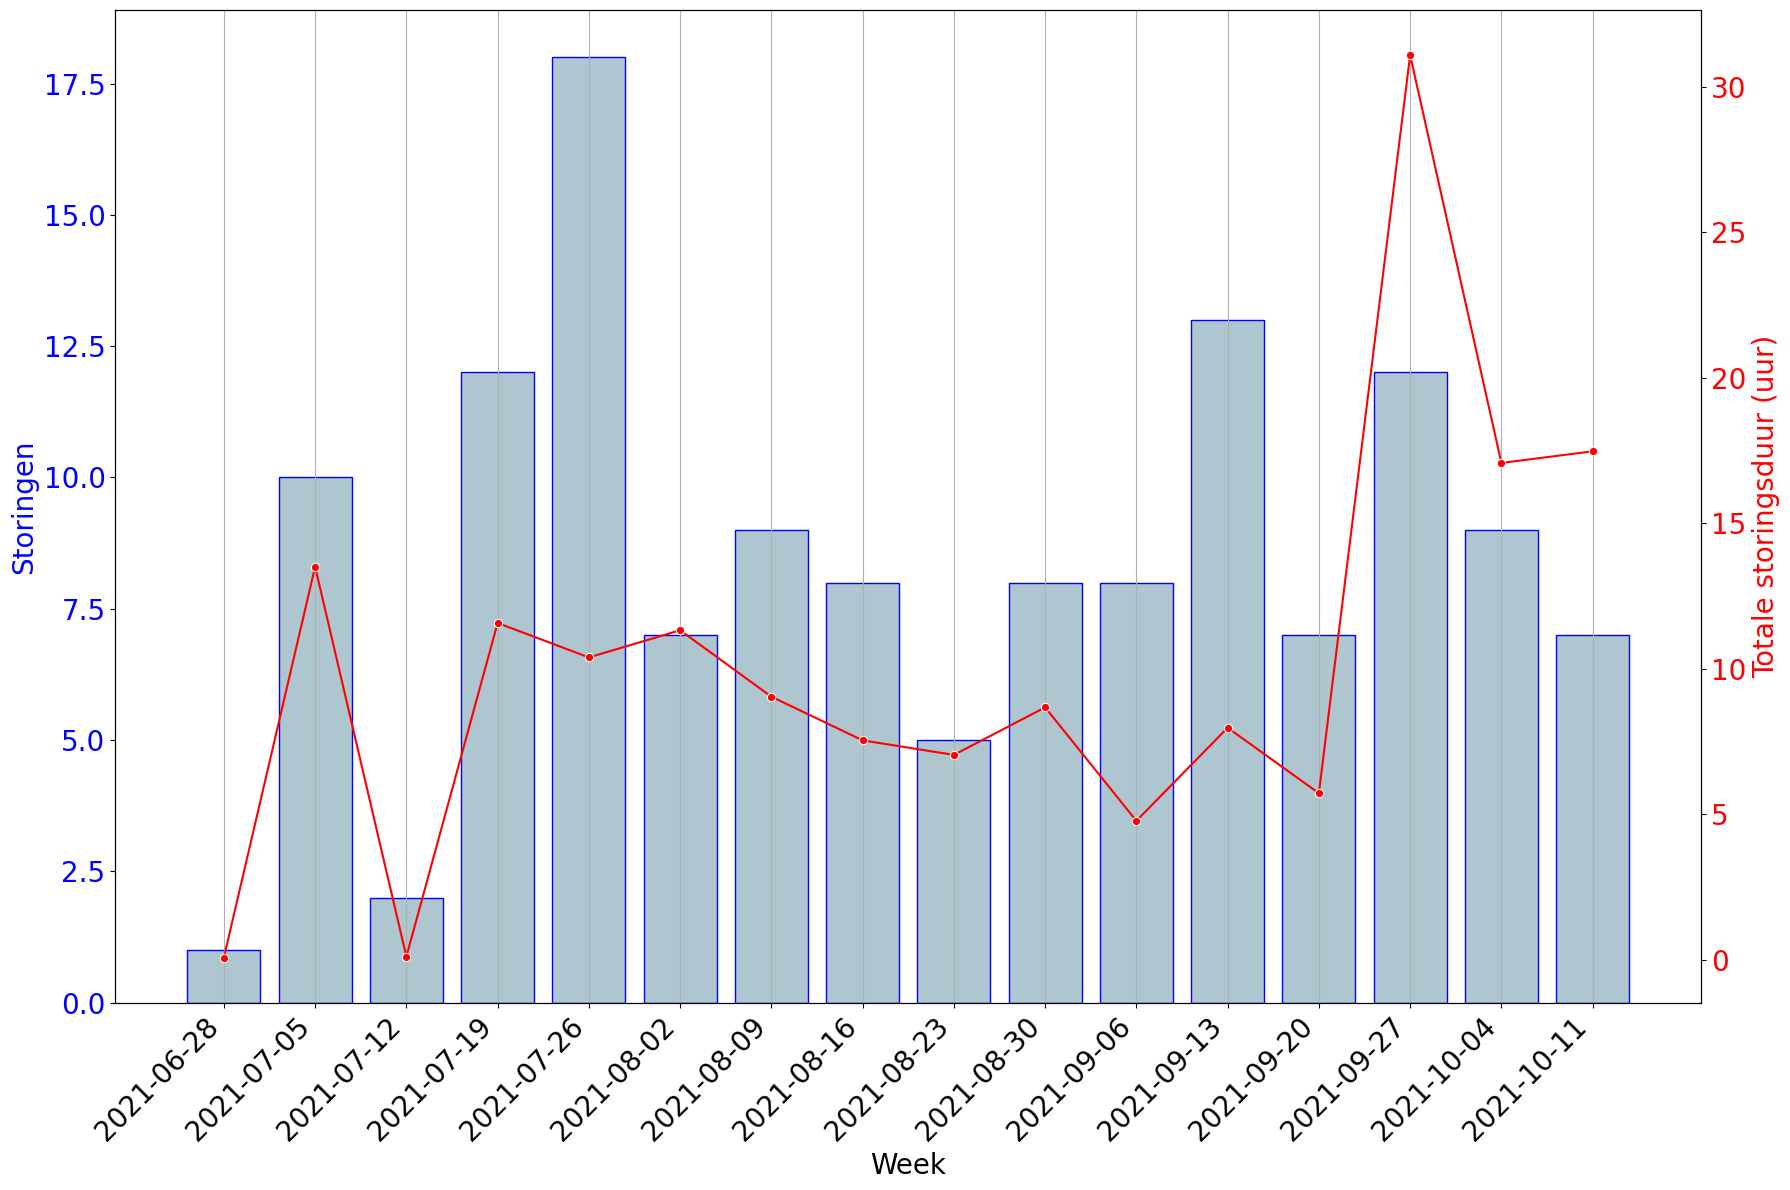

In [14]:
# Plot weekly disruptions and average disruption time
fig, ax1 = plt.subplots(figsize=(18,12))

# Plot weekly disruptions
sns.barplot(data=weekly_summary, x='datum', y='counts', color='blue', edgecolor='blue', facecolor='#AEC6CF', ax=ax1)

ax2 = ax1.twinx()

# Plot average disruption time
sns.lineplot(data=weekly_summary['total_disruption_time'], color='red', marker='o', ax=ax2)

# Set axes labels
ax1.xaxis.grid(True)
ax1.set_xlabel('Week', fontsize=20)
ax1.set_ylabel('Storingen', color='blue', fontsize=20)
ax1.tick_params(axis='y', labelcolor='blue', labelsize=20)

ax2.set_ylabel('Totale storingsduur (uur)', color='red', fontsize=20)
ax2.tick_params(axis='y', labelcolor='red', labelsize=20)
ax1.set_xticklabels(weekly_summary['datum'].dt.strftime('%Y-%m-%d'), rotation=45, ha='right', fontsize=20)
#plt.title('Storingen op het treinnetwerk per week.)

plt.savefig('Weekstoringen_grafiek.png', dpi=300)
plt.tight_layout()  
plt.show()

#### Daily distribution of disruptions

In [15]:
# Group disruptions by days
daily_summary = df_disruption_schiphol.groupby(df_disruption_schiphol['datum'].dt.day_name()).agg(
    counts=('Disruption Time (Minutes)', 'size'),
    total_disruption_time=('Disruption Time (Minutes)', 'sum')).reset_index()

# Transform delays from minutes to hours
daily_summary['total_disruption_time'] = daily_summary['total_disruption_time'] / 60

# Sort the dataframe from dates into days
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_summary['datum'] = pd.Categorical(daily_summary['datum'], categories=ordered_days, ordered=True)
daily_summary = daily_summary.sort_values('datum').reset_index(drop=True)

# Translate days to Dutch
daily_summary['datum'] = ['Maandag', 'Dinsdag', 'Woensdag', 'Donderdag', 'Vrijdag', 'Zaterdag', 'Zondag']

/var/folders/sh/90yjgzpn6435lg4k792260jw0000gn/T/ipykernel_44447/826783627.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(daily_summary['datum'], rotation=45, ha='right', fontsize=20)


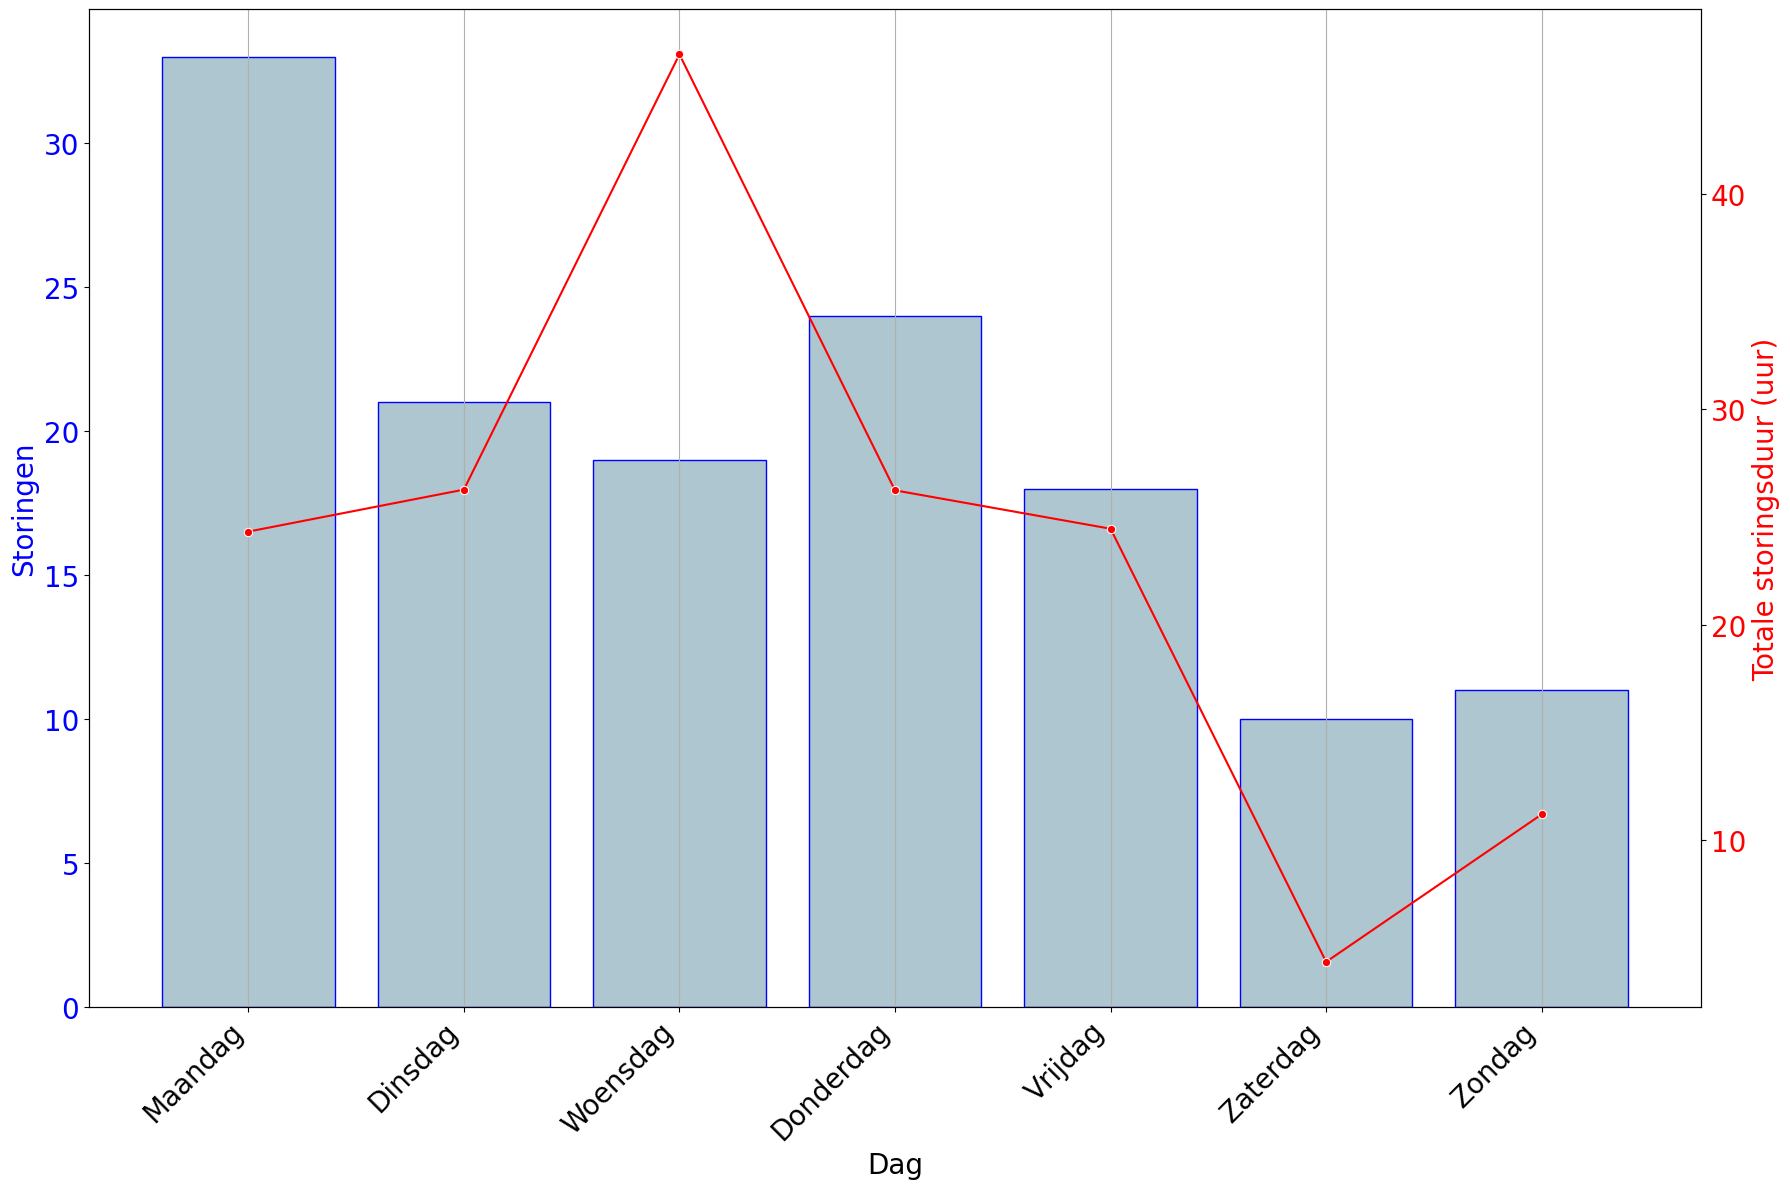

In [16]:
# Plot daily dispruption and average disruption time
fig, ax1 = plt.subplots(figsize=(18,12))

# Daily disruption
sns.barplot(data=daily_summary, x='datum', y='counts', color='blue', edgecolor='blue', facecolor='#AEC6CF', ax=ax1)

ax2 = ax1.twinx()

# Average disruption time
sns.lineplot(data=daily_summary['total_disruption_time'], color='red', marker='o', ax=ax2)

# Set axes labels
ax1.xaxis.grid(True)
ax1.set_xlabel('Dag', fontsize=20)
ax1.set_ylabel('Storingen', color='blue', fontsize=20)
ax1.tick_params(axis='y', labelcolor='blue', labelsize=20)
ax1.set_xticklabels(daily_summary['datum'], rotation=45, ha='right', fontsize=20)

ax2.set_ylabel('Totale storingsduur (uur)', color='red', fontsize=20)
ax2.tick_params(axis='y', labelcolor='red', labelsize=20)

#plt.title('Storingen op het treinnetwerk per week.)
plt.savefig('Dag_storingen_grafiek.png', dpi=300)
plt.tight_layout() 
plt.show()

#### Hourly distribution of disruptions

In [17]:
# Define the custom function to group times into the correct hour bins
def assign_hour_group(time):
    total_minutes = time.total_seconds() // 60
    hours = int(total_minutes // 60)            # Return integer number of hours
    minutes = int(total_minutes % 60)           # Return the integer number of minutes (use module operation)

    # Partition the observations into hour groups where 0 is the first group and 23 the last
    if (hours == 0 and minutes >= 30) or (hours == 1 and minutes < 30):
        return 1
    elif (hours == 1 and minutes >= 30) or (hours == 2 and minutes < 30):
        return 2
    elif (hours == 2 and minutes >= 30) or (hours == 3 and minutes < 30):
        return 3
    elif (hours == 3 and minutes >= 30) or (hours == 4 and minutes < 30):
        return 4
    elif (hours == 4 and minutes >= 30) or (hours == 5 and minutes < 30):
        return 5
    elif (hours == 5 and minutes >= 30) or (hours == 6 and minutes < 30):
        return 6
    elif (hours == 6 and minutes >= 30) or (hours == 7 and minutes < 30):
        return 7
    elif (hours == 7 and minutes >= 30) or (hours == 8 and minutes < 30):
        return 8
    elif (hours == 8 and minutes >= 30) or (hours == 9 and minutes < 30):
        return 9
    elif (hours == 9 and minutes >= 30) or (hours == 10 and minutes < 30):
        return 10
    elif (hours == 10 and minutes >= 30) or (hours == 11 and minutes < 30):
        return 11
    elif (hours == 11 and minutes >= 30) or (hours == 12 and minutes < 30):
        return 12
    elif (hours == 12 and minutes >= 30) or (hours == 13 and minutes < 30):
        return 13
    elif (hours == 13 and minutes >= 30) or (hours == 14 and minutes < 30):
        return 14
    elif (hours == 14 and minutes >= 30) or (hours == 15 and minutes < 30):
        return 15
    elif (hours == 15 and minutes >= 30) or (hours == 16 and minutes < 30):
        return 16
    elif (hours == 16 and minutes >= 30) or (hours == 17 and minutes < 30):
        return 17
    elif (hours == 17 and minutes >= 30) or (hours == 18 and minutes < 30):
        return 18
    elif (hours == 18 and minutes >= 30) or (hours == 19 and minutes < 30):
        return 19
    elif (hours == 19 and minutes >= 30) or (hours == 20 and minutes < 30):
        return 20
    elif (hours == 20 and minutes >= 30) or (hours == 21 and minutes < 30):
        return 21
    elif (hours == 21 and minutes >= 30) or (hours == 22 and minutes < 30):
        return 22
    elif (hours == 22 and minutes >= 30) or (hours == 23 and minutes < 30):
        return 23
    elif (hours == 23 and minutes >= 30) or (hours == 0 and minutes < 30):
        return 0

In [18]:
# Apply the function to create a new variable with hour groups
df_disruption_schiphol['hour_group'] = df_disruption_schiphol['tijd_van'].apply(assign_hour_group)

# Group number and magnitude of disruptions per hour group 
grouped_df = df_disruption_schiphol.groupby('hour_group').agg(
    counts=('Disruption Time (Minutes)', 'size') , 
    total_disruption_time=('Disruption Time (Minutes)', 'sum'),  
).reset_index()

# Transform delays from minutes to hours
grouped_df['total_disruption_time'] = grouped_df['total_disruption_time'] / 60

print(grouped_df)

    hour_group  counts  total_disruption_time
0            1       2               8.433333
1            2       1               3.833333
2            3       2               2.566667
3            4       1              15.433333
4            5       1               1.116667
5            6       4               6.550000
6            7       4               3.850000
7            8       6               3.283333
8            9      11               7.650000
9           10       7               4.933333
10          11       7               6.883333
11          12       9               9.716667
12          13       8              10.266667
13          14       7              10.400000
14          15       6              11.716667
15          16      15              28.083333
16          17       7               3.783333
17          18      14               6.450000
18          19      14              11.866667
19          20       4               1.650000
20          21       2            

/var/folders/sh/90yjgzpn6435lg4k792260jw0000gn/T/ipykernel_44447/2572660059.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(grouped_df['hour_group'], rotation=45, ha='right', fontsize=20)


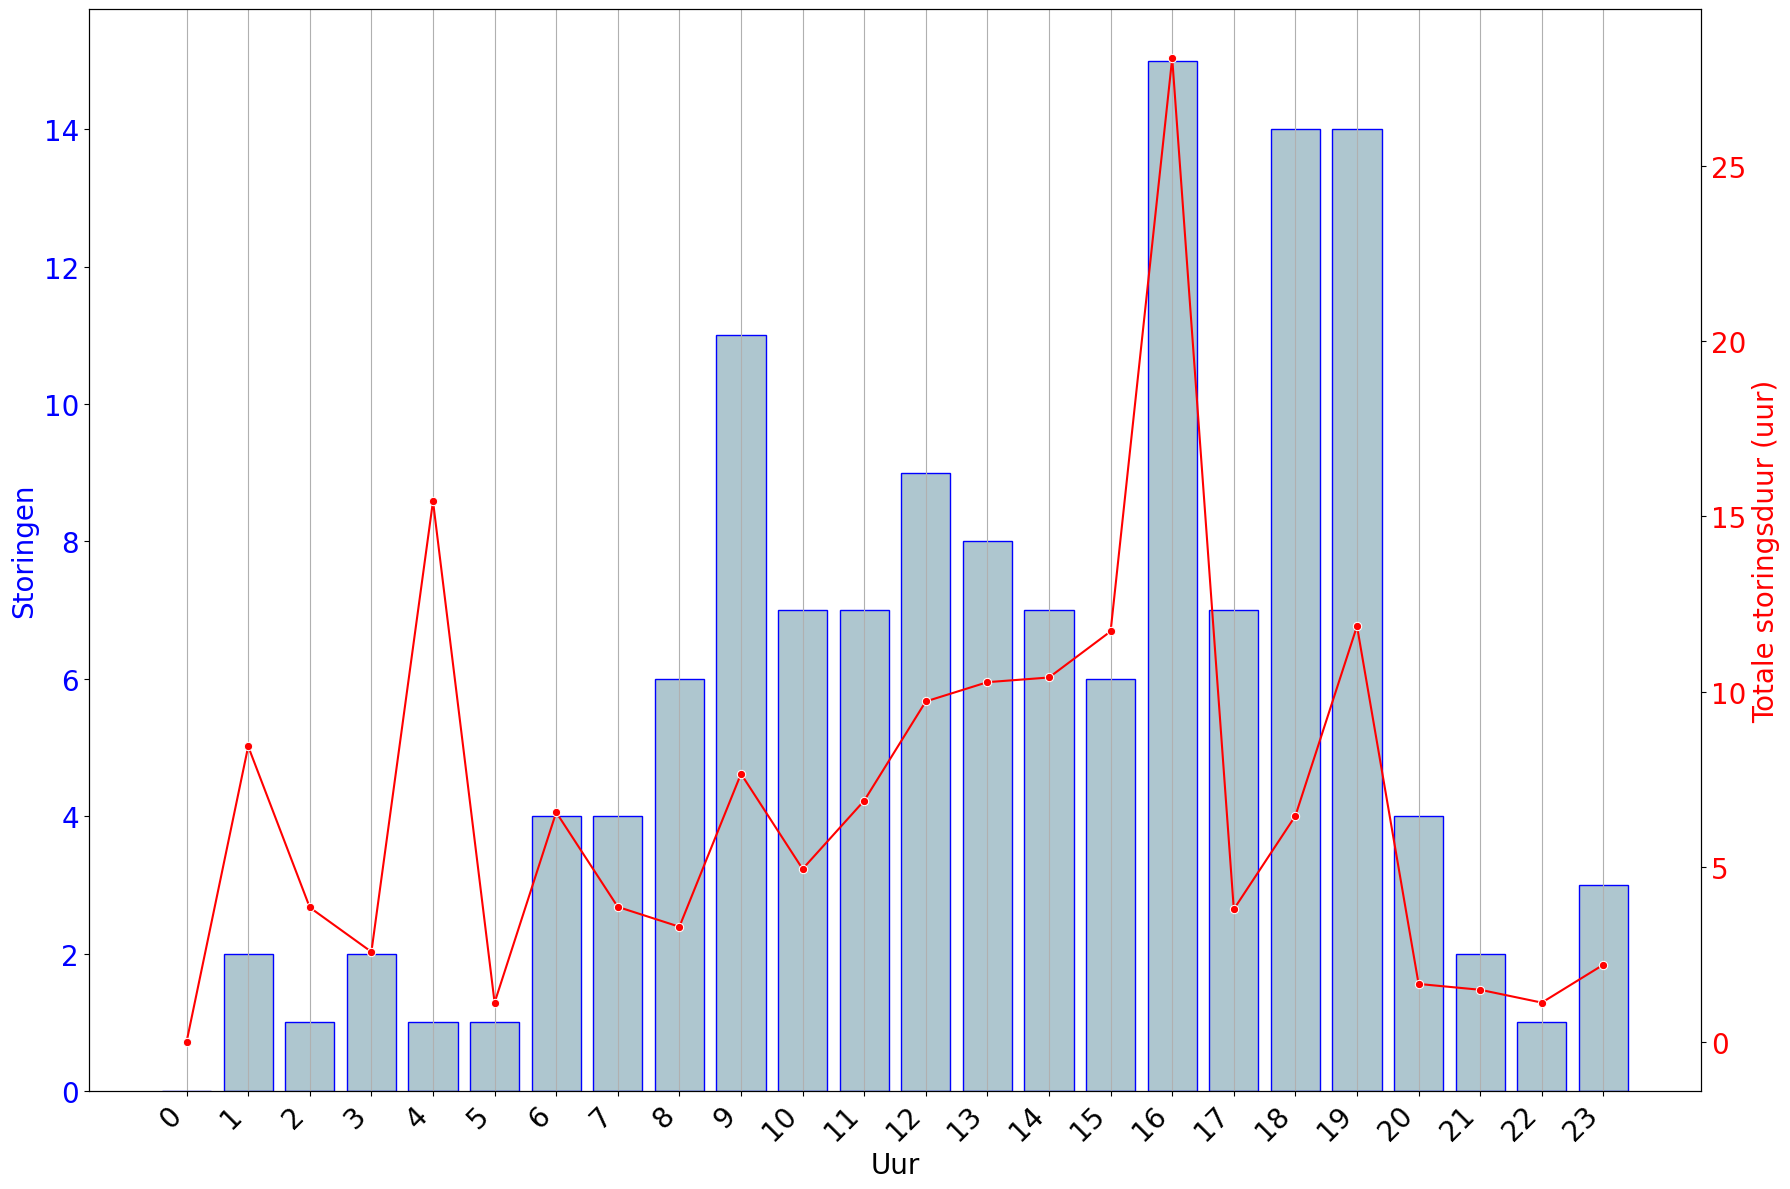

In [19]:
# Add missing group '0' to the observations for visual purpose
missing_group = {'hour_group': 0, 'counts': 0,'total_disruption_time': 0.00}
missing_group_df = pd.DataFrame([missing_group])
grouped_df = pd.concat([missing_group_df, grouped_df], ignore_index=True)

# Plot hourly disruptions and average disruption time
fig, ax1 = plt.subplots(figsize=(18,12))

# Hourly disruptions
sns.barplot(data=grouped_df, x='hour_group', y='counts', color='blue', edgecolor='blue', facecolor='#AEC6CF', ax=ax1)
ax2 = ax1.twinx()

# Average disruption time
sns.lineplot(data=grouped_df['total_disruption_time'], color='red', marker='o', ax=ax2)

# Set axes labels
ax1.xaxis.grid(True)
ax1.set_xlabel('Uur', fontsize=20)
ax1.set_ylabel('Storingen', color='blue', fontsize=20)
ax1.tick_params(axis='y', labelcolor='blue', labelsize=20)
ax1.set_xticklabels(grouped_df['hour_group'], rotation=45, ha='right', fontsize=20)

ax2.set_ylabel('Totale storingsduur (uur)', color='red', fontsize=20)
ax2.tick_params(axis='y', labelcolor='red', labelsize=20)

#plt.title('Storingen op het treinnetwerk per week.)
plt.savefig('Uurstoringen_grafiek.png', dpi=300)
plt.tight_layout()  
plt.show()

### Analyse trips together

In [20]:
# Extract the date 
df['departure_time'] = pd.to_datetime(df['departure_time'])
df['Date'] = df['departure_time'].dt.strftime('%Y-%m-%d')

df['arrival_time'] = pd.to_datetime(df['arrival_time'])
df.loc[df['Date'].isna(), 'Date'] = df.loc[df['Date'].isna(), 'arrival_time'].dt.strftime('%Y-%m-%d')


In [21]:
df_grouped = df.groupby(['trip_id','Date'])
df_sorted = df_grouped.apply(lambda x: x.sort_values(by='arrival_time', ascending=True))


/var/folders/sh/90yjgzpn6435lg4k792260jw0000gn/T/ipykernel_44447/416104437.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sorted = df_grouped.apply(lambda x: x.sort_values(by='arrival_time', ascending=True))


In [22]:
# Incoming trains schiphol
df_schiphol = df[df['stop_name'] == 'Schiphol Airport']

####################################################################################################

### 1.4 Mapping of train stations and lines


####################################################################################################

In [23]:
# Extract the unique railways lines 
geojson_file_1 = 'hotosm_nld_railways_lines_geojson.geojson'  
gdf_1 = gpd.read_file(geojson_file_1)
unique_names = gdf_1['name'].unique()

# Write unique names to csv
unique_names_adj = pd.DataFrame(unique_names)
unique_names_adj.to_csv('Unique_route_names.csv', index=False)

### Map of all train lines and stations

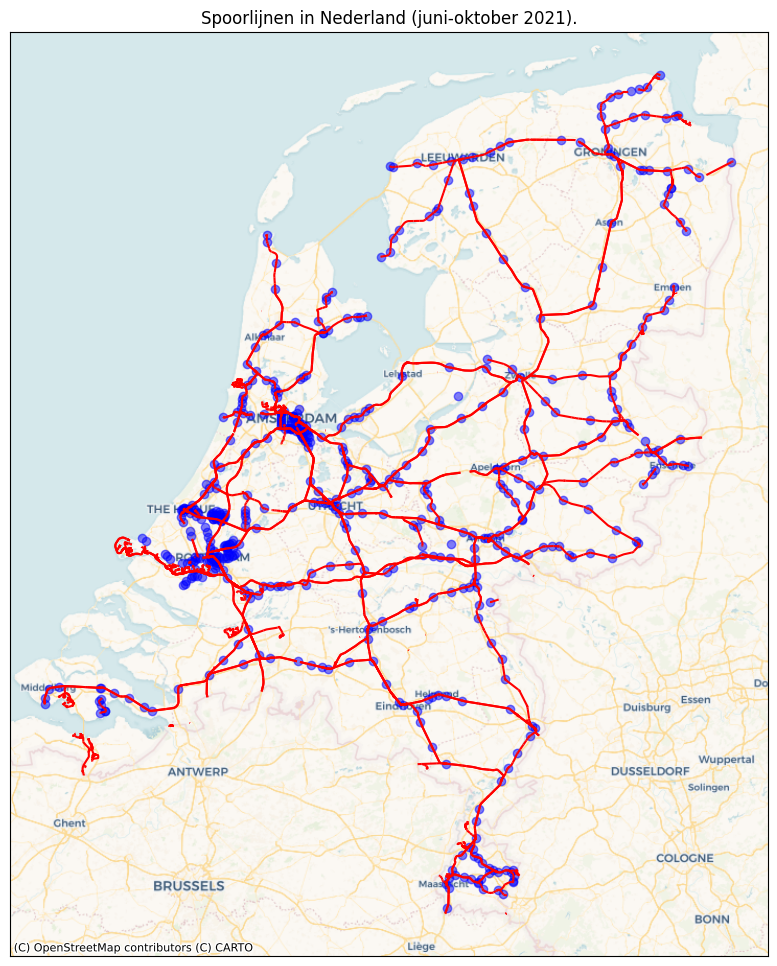

In [24]:
# Load the railways lines into GeoDataFrame
geojson_file_1 = 'hotosm_nld_railways_lines_geojson.geojson'  
gdf_1 = gpd.read_file(geojson_file_1)

# Load the railways stations and important points into GeoDataFrame
geojson_file_2 = 'hotosm_nld_railways_points_geojson.geojson'  
gdf_2 = gpd.read_file(geojson_file_2)

# Convert GeoDataFrames to Web Mercator (EPSG:3857) to align with basemap Netherlands
gdf_1 = gdf_1.to_crs(epsg=3857)
gdf_2 = gdf_2.to_crs(epsg=3857)

# Create the plot 
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xticks([])  
ax.set_yticks([]) 
ax.set_xlabel('')  
ax.set_ylabel('') 

# Plot the railways lines
gdf_1.plot(ax=ax, color='red', markersize=1, label="GeoJSON Layer 1")

# Plot the stations and important points
gdf_2.plot(ax=ax, color='blue', linewidth=1, alpha=0.5, label="GeoJSON Layer 2")

# Add a basemap for the Netherlands 
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

# Set labels, title, and show the plot
ax.set_title("Spoorlijnen in Nederland (juni-oktober 2021).")

plt.savefig('Train_map.png', dpi=300)
plt.show()

#### (Empty) Map of most disturbed lines

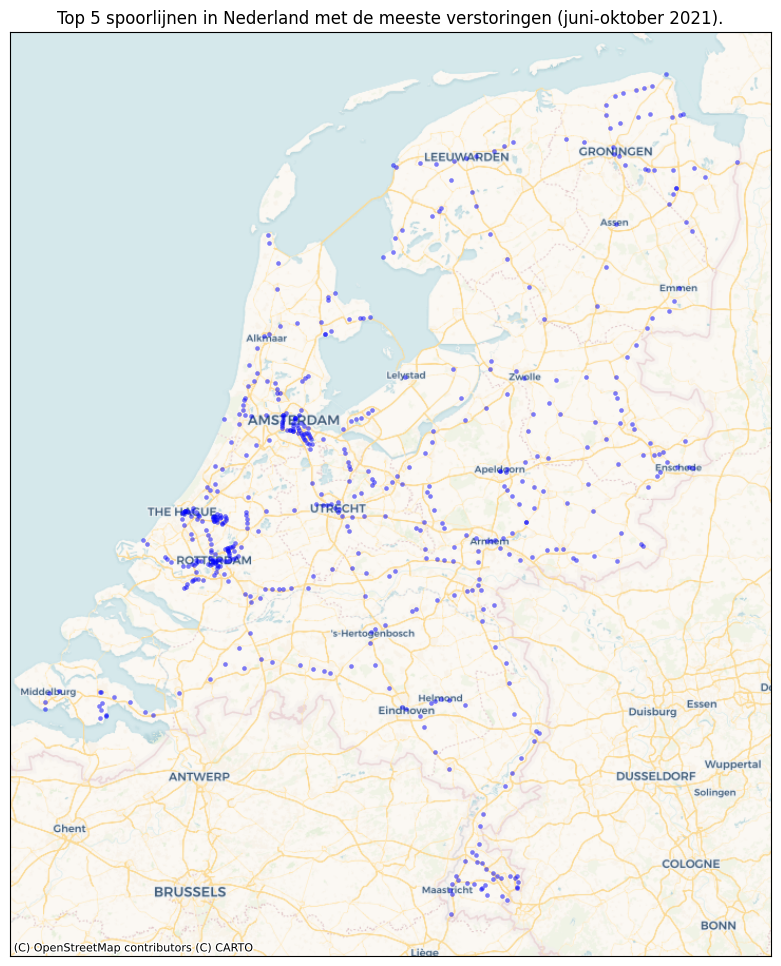

In [25]:
# Load the railways stations and important points into GeoDataFrame
geojson_file_1 = 'hotosm_nld_railways_points_geojson.geojson'  
gdf_1 = gpd.read_file(geojson_file_1)

# Convert GeoDataFrame to Web Mercator (EPSG:3857) to align with basemap Netherlands
gdf_1 = gdf_1.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xticks([])  
ax.set_yticks([]) 
ax.set_xlabel('')  
ax.set_ylabel('') 

# Plot the stations and important points
gdf_1.plot(ax=ax, color='blue', markersize=10, linewidth=0.1, alpha=0.5, label="GeoJSON Layer 1")

# Add a basemap for the Netherlands using Contextily
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

# Set labels, title, and show the plot
ax.set_title("Top 5 spoorlijnen in Nederland met de meeste verstoringen (juni-oktober 2021).")

plt.savefig('Train_map_top_5.png', dpi=300)
plt.show()

#### (Empty) Map of most disturbed lines around Schiphol

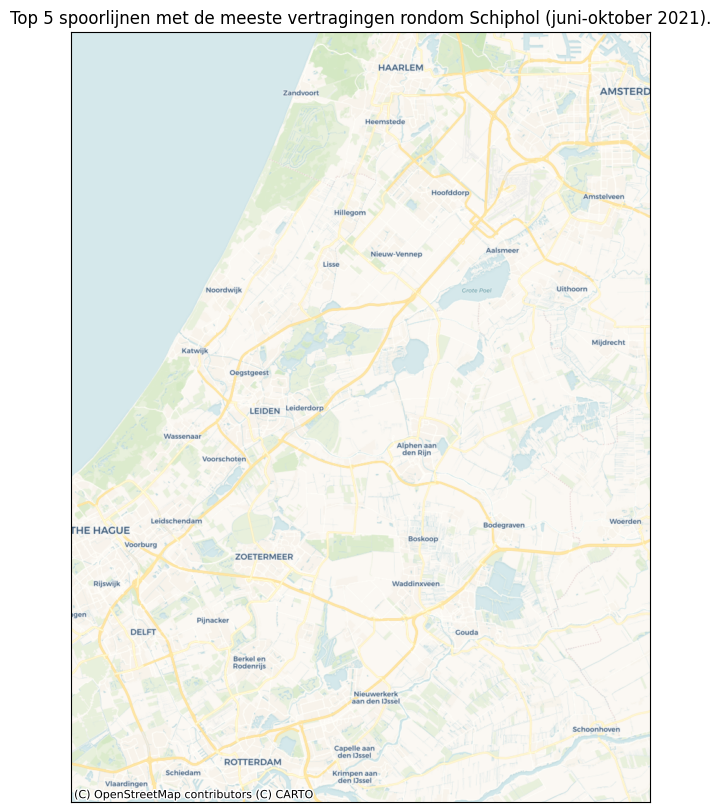

In [26]:
# Load the railways stations and important points into GeoDataFrame
geojson_file_1 = 'hotosm_nld_railways_lines_geojson.geojson'  
gdf_1 = gpd.read_file(geojson_file_1)

# Convert GeoDataFrame to Web Mercator (EPSG:3857) to align with basemap Netherlands
gdf_1 = gdf_1.to_crs(epsg=3857)

# route_names = [
#     "Oude Lijn",          # Haarlem-Zandvoort
#     "Montzenroute",       # Heerlen-Aachen Hbf
#     "Bentheimer Eisenbahn",# Hengelo-Bielefeld
#     "Wunderline",         # Zwolle-Groningen
#     "Staatslijn E"        # Sittard-Maastricht (add manually if missing from the list)
# ]

route_names = ["Oude Lijn"]

gdf_1_filtered = gdf_1[gdf_1['name'].isin(route_names)]

# Create the plot 
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xticks([])  
ax.set_yticks([]) 
ax.set_xlabel('')  
ax.set_ylabel('') 

# Plot the stations and important points
gdf_1_filtered.plot(ax=ax, color='red', linewidth=0.0,  label="Selected Routes")

# Add a basemap for the Netherlands 
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

# Set labels, title, and show the plot
ax.set_title("Top 5 spoorlijnen met de meeste vertragingen rondom Schiphol (juni-oktober 2021).")
#plt.legend()  
plt.savefig("Schiphol_map_top_5.png", dpi=300)
plt.show()

In [27]:
# Code to plot each train track individually 


# import geopandas as gpd
# import matplotlib.pyplot as plt
# import contextily as ctx

# # Step 1: Load the first GeoJSON file (e.g., railway lines) into a GeoDataFrame
# geojson_file_1 = 'hotosm_nld_railways_lines_geojson.geojson'  # Replace with your file path
# gdf_1 = gpd.read_file(geojson_file_1)

# # Step 2: Load the second GeoJSON file (e.g., railway points) into a GeoDataFrame
# geojson_file_2 = 'hotosm_nld_railways_points_geojson.geojson'  
# gdf_2 = gpd.read_file(geojson_file_2)

# # Step 3: Convert both GeoDataFrames to Web Mercator (EPSG:3857) for compatibility with basemaps
# gdf_1 = gdf_1.to_crs(epsg=3857)
# gdf_2 = gdf_2.to_crs(epsg=3857)

# # Step 4: Get the unique route names
# unique_names = gdf_1['name'].unique()

# # Step 5: Loop through each unique name and create individual plots
# for unique_name in unique_names:
#     # Filter the GeoDataFrame to get only the current unique route
#     gdf_1_unique = gdf_1[gdf_1['name'] == unique_name]

#     # Create the plot
#     fig, ax = plt.subplots(figsize=(10, 10))

#     # Plot the current route in red
#     gdf_1_unique.plot(ax=ax, color='red', linewidth=2, label=f"Route: {unique_name}")

#     # Plot the second GeoJSON data (e.g., railways points) in blue, with a lighter marker
#     gdf_2.plot(ax=ax, color='blue', markersize=5, alpha=0.5, label="Railway Points")

#     # Add a basemap for the Netherlands using Contextily
#     ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

#     # Set title, labels, and show plot
#     ax.set_title(f"Route: {unique_name} Over the Netherlands")
#     plt.legend()  # Show legend to differentiate the layers

#     # Show each plot
#     plt.show()


## 2. Train timetable & Flights
* Distribution of departure times from Schiphol

In [28]:
def assign_hour_group2(time):
    hours = time.hour
    minutes = time.minute

    # Hour group logic
    if (hours == 0 and minutes >= 30) or (hours == 1 and minutes < 30):
        return 1
    elif (hours == 1 and minutes >= 30) or (hours == 2 and minutes < 30):
        return 2
    elif (hours == 2 and minutes >= 30) or (hours == 3 and minutes < 30):
        return 3
    elif (hours == 3 and minutes >= 30) or (hours == 4 and minutes < 30):
        return 4
    elif (hours == 4 and minutes >= 30) or (hours == 5 and minutes < 30):
        return 5
    elif (hours == 5 and minutes >= 30) or (hours == 6 and minutes < 30):
        return 6
    elif (hours == 6 and minutes >= 30) or (hours == 7 and minutes < 30):
        return 7
    elif (hours == 7 and minutes >= 30) or (hours == 8 and minutes < 30):
        return 8
    elif (hours == 8 and minutes >= 30) or (hours == 9 and minutes < 30):
        return 9
    elif (hours == 9 and minutes >= 30) or (hours == 10 and minutes < 30):
        return 10
    elif (hours == 10 and minutes >= 30) or (hours == 11 and minutes < 30):
        return 11
    elif (hours == 11 and minutes >= 30) or (hours == 12 and minutes < 30):
        return 12
    elif (hours == 12 and minutes >= 30) or (hours == 13 and minutes < 30):
        return 13
    elif (hours == 13 and minutes >= 30) or (hours == 14 and minutes < 30):
        return 14
    elif (hours == 14 and minutes >= 30) or (hours == 15 and minutes < 30):
        return 15
    elif (hours == 15 and minutes >= 30) or (hours == 16 and minutes < 30):
        return 16
    elif (hours == 16 and minutes >= 30) or (hours == 17 and minutes < 30):
        return 17
    elif (hours == 17 and minutes >= 30) or (hours == 18 and minutes < 30):
        return 18
    elif (hours == 18 and minutes >= 30) or (hours == 19 and minutes < 30):
        return 19
    elif (hours == 19 and minutes >= 30) or (hours == 20 and minutes < 30):
        return 20
    elif (hours == 20 and minutes >= 30) or (hours == 21 and minutes < 30):
        return 21
    elif (hours == 21 and minutes >= 30) or (hours == 22 and minutes < 30):
        return 22
    elif (hours == 22 and minutes >= 30) or (hours == 23 and minutes < 30):
        return 23
    elif (hours == 23 and minutes >= 30) or (hours == 0 and minutes < 30):
        return 0

####################################################################################################

### 2.1 Preprocessing Flights

* Flights data (correct data type, introduce new variable, remove duplicates)

####################################################################################################

In [29]:
# Format date and time into datetime columns
df_flights['datetime'] = pd.to_datetime(df_flights['date'] + ' ' + df_flights['time'], format='%Y-%m-%d %I:%M%p') # Format: Year-Month-Day I (12-hour): M (Min) p (AM/PM)

# Apply the function to create a new column with hour groups
df_flights['hour_group'] = df_flights['datetime'].apply(assign_hour_group2)

# See duplicates 
# df_flights = df_flights[df_flights.duplicated(subset=['status', 'time', 'airline', 'origin', 'date','movement','destination'], keep=False)]

# Remove duplicates (316 removed: 341.557 to 341.241)
df_flights = df_flights.drop_duplicates(subset=['status', 'time', 'airline', 'origin', 'date','movement','destination'], keep='first')

# # Filter on flights departing from Amsterdam 
# Remove observations that have Amsterdam as origin but arrive due to different reasons (diverting, unknown)
df_flights_departure = df_flights[(df_flights['origin'] == 'AMS') & (df_flights['movement'] == 'departing')]

####  Histogram: Departing Flights Schiphol

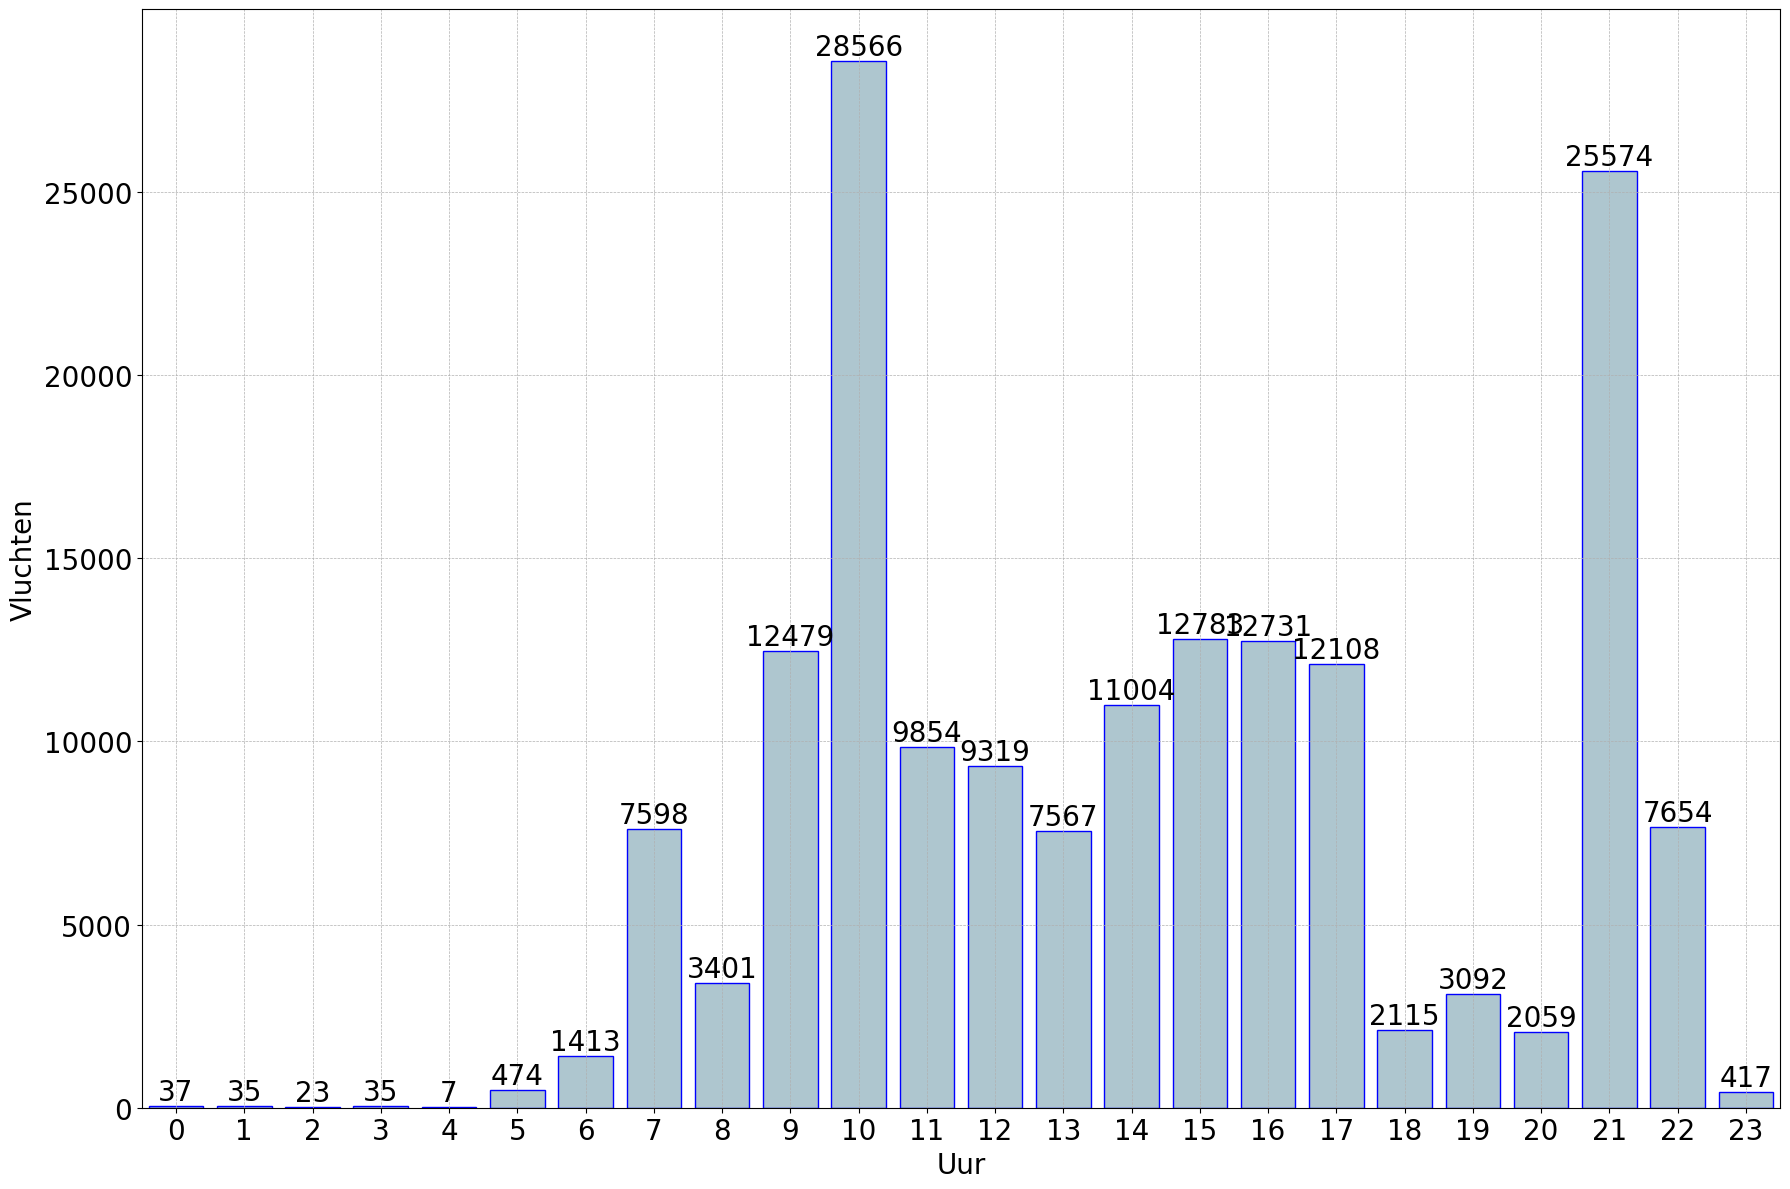

In [30]:
# Prepare dataset 

# Count the number of departing flights per hour group
grouped_departing_flights = df_flights_departure.groupby('hour_group').size().reset_index().rename(columns={0: 'counts'})

# Departing flights per hour group
plt.figure(figsize=(18,12))
ax = sns.barplot(data=grouped_departing_flights, x='hour_group', y='counts', color='blue', edgecolor='blue', facecolor='#AEC6CF')

# Display absolute number of departing flight in each bar
for bar in ax.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), int(bar.get_height()), ha='center', va='bottom', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Uur', fontsize=20)
plt.ylabel('Vluchten', fontsize=20)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('Vluchten_grafiek.png', dpi=300)
plt.tight_layout()  
plt.show()

####################################################################################################

## 2.2 Preprocessing Trains Dienstregeling
* Remove duplicates, introduce new delay variables 
* Filter on departing delays 
* Global statistics

####################################################################################################

In [31]:
# Duplicates 
# duplicates = df[df.duplicated(subset=['arrival_time', 'departure_time', 'stop_name', 'route_id'], keep=False)]

# Remove duplicates (1631 removed: 69.890 to 68259 obs)
df = df.drop_duplicates(subset=['arrival_time', 'departure_time', 'stop_name', 'route_id'], keep='first')

In [32]:
# General delay
df['delay_indicator'] = (df['arrival_delay'] != 0) | (df['departure_delay'] != 0)

df['delay_indicator'] = df['delay_indicator'].astype(int)

# 5 Minutes delay
df['delay_indicator_5min'] = (df['arrival_delay'] >= 300) | (df['departure_delay'] >= 300)

df['delay_indicator_5min'] = df['delay_indicator_5min'].astype(int)

# 15 Minutes delay
df['delay_indicator_15min'] = (df['arrival_delay'] >= 900) | (df['departure_delay'] >= 900)

df['delay_indicator_15min'] = df['delay_indicator_15min'].astype(int)

/var/folders/sh/90yjgzpn6435lg4k792260jw0000gn/T/ipykernel_44447/1916653316.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delay_indicator'] = (df['arrival_delay'] != 0) | (df['departure_delay'] != 0)
/var/folders/sh/90yjgzpn6435lg4k792260jw0000gn/T/ipykernel_44447/1916653316.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delay_indicator'] = df['delay_indicator'].astype(int)
/var/folders/sh/90yjgzpn6435lg4k792260jw0000gn/T/ipykernel_44447/1916653316.py:7: SettingWithCopyWarning: 
A value i

In [33]:
# Filter trains arriving at schiphol
df_trains_schiphol = df[(df['arrival_time'].notna()) & (df['stop_name'].str.contains('Schiphol'))]

In [34]:
# Create hour groups for the train data
df_trains_schiphol.loc[:, 'arrival_time'] = pd.to_datetime(df_trains_schiphol['arrival_time'])
df_trains_schiphol.loc[:, 'hour_group'] = df_trains_schiphol.copy()['arrival_time'].apply(assign_hour_group2)

/var/folders/sh/90yjgzpn6435lg4k792260jw0000gn/T/ipykernel_44447/1655611853.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trains_schiphol.loc[:, 'hour_group'] = df_trains_schiphol.copy()['arrival_time'].apply(assign_hour_group2)


#### Global statistics 

In [42]:
# Proportion of the trains without delay
delays = len(df[(df['departure_delay'] > 0) | (df['arrival_delay'] > 0)])
total_tracks = len(df['departure_delay'])
punctuality = (1 - delays / total_tracks) * 100
print(f'Punctuality: {punctuality} %')

# Proportion of the trains arriving at Schiphol without delay
delays_schiphol = len(df_trains_schiphol[(df_trains_schiphol['arrival_delay'] > 0)])
total_tracks_schiphol = len(df_trains_schiphol)
punctuality_schiphol = (1 - delays_schiphol / total_tracks_schiphol) * 100
print(f'Punctuality Schiphol: {punctuality_schiphol} %')

# Proportion of the trains arriving with less than 5 min delay at Schiphol 
delays = np.sum(df_trains_schiphol['delay_indicator_5min'])
total_tracks_schiphol = len(df_trains_schiphol)
punctuality_schiphol_5min = (1 - delays / total_tracks_schiphol) * 100
print(f'Punctuality Schiphol delay < 5 min: {punctuality_schiphol_5min}')

# Proportion of the trains arriving with less than 15 min delay at Schiphol 
delays = np.sum(df_trains_schiphol['delay_indicator_15min'])
total_tracks_schiphol = len(df_trains_schiphol)
punctuality_schiphol_15min = (1 - delays / total_tracks_schiphol) * 100
print(f'Punctuality Schiphol delay < 15 min: {punctuality_schiphol_15min}')

# Average delay Schiphol
average_delay = np.mean(df_trains_schiphol[df_trains_schiphol['delay_indicator'] == 1]['arrival_delay'])
print(f'Average delay Schiphol: {average_delay}')

# Average delay 
average_delay = np.mean(df[df['delay_indicator'] == 1]['arrival_delay'])
print(f'Average delay : {average_delay}')

Punctuality: 72.54867490001318 %
Punctuality Schiphol: 74.41804942103379 %
Punctuality Schiphol delay < 5 min: 96.70526441446819
Punctuality Schiphol delay < 15 min: 99.48668974573236
Average delay Schiphol: 174.04106392907138
Average delay : 118.14942896787277


#### Histogram arriving trains 

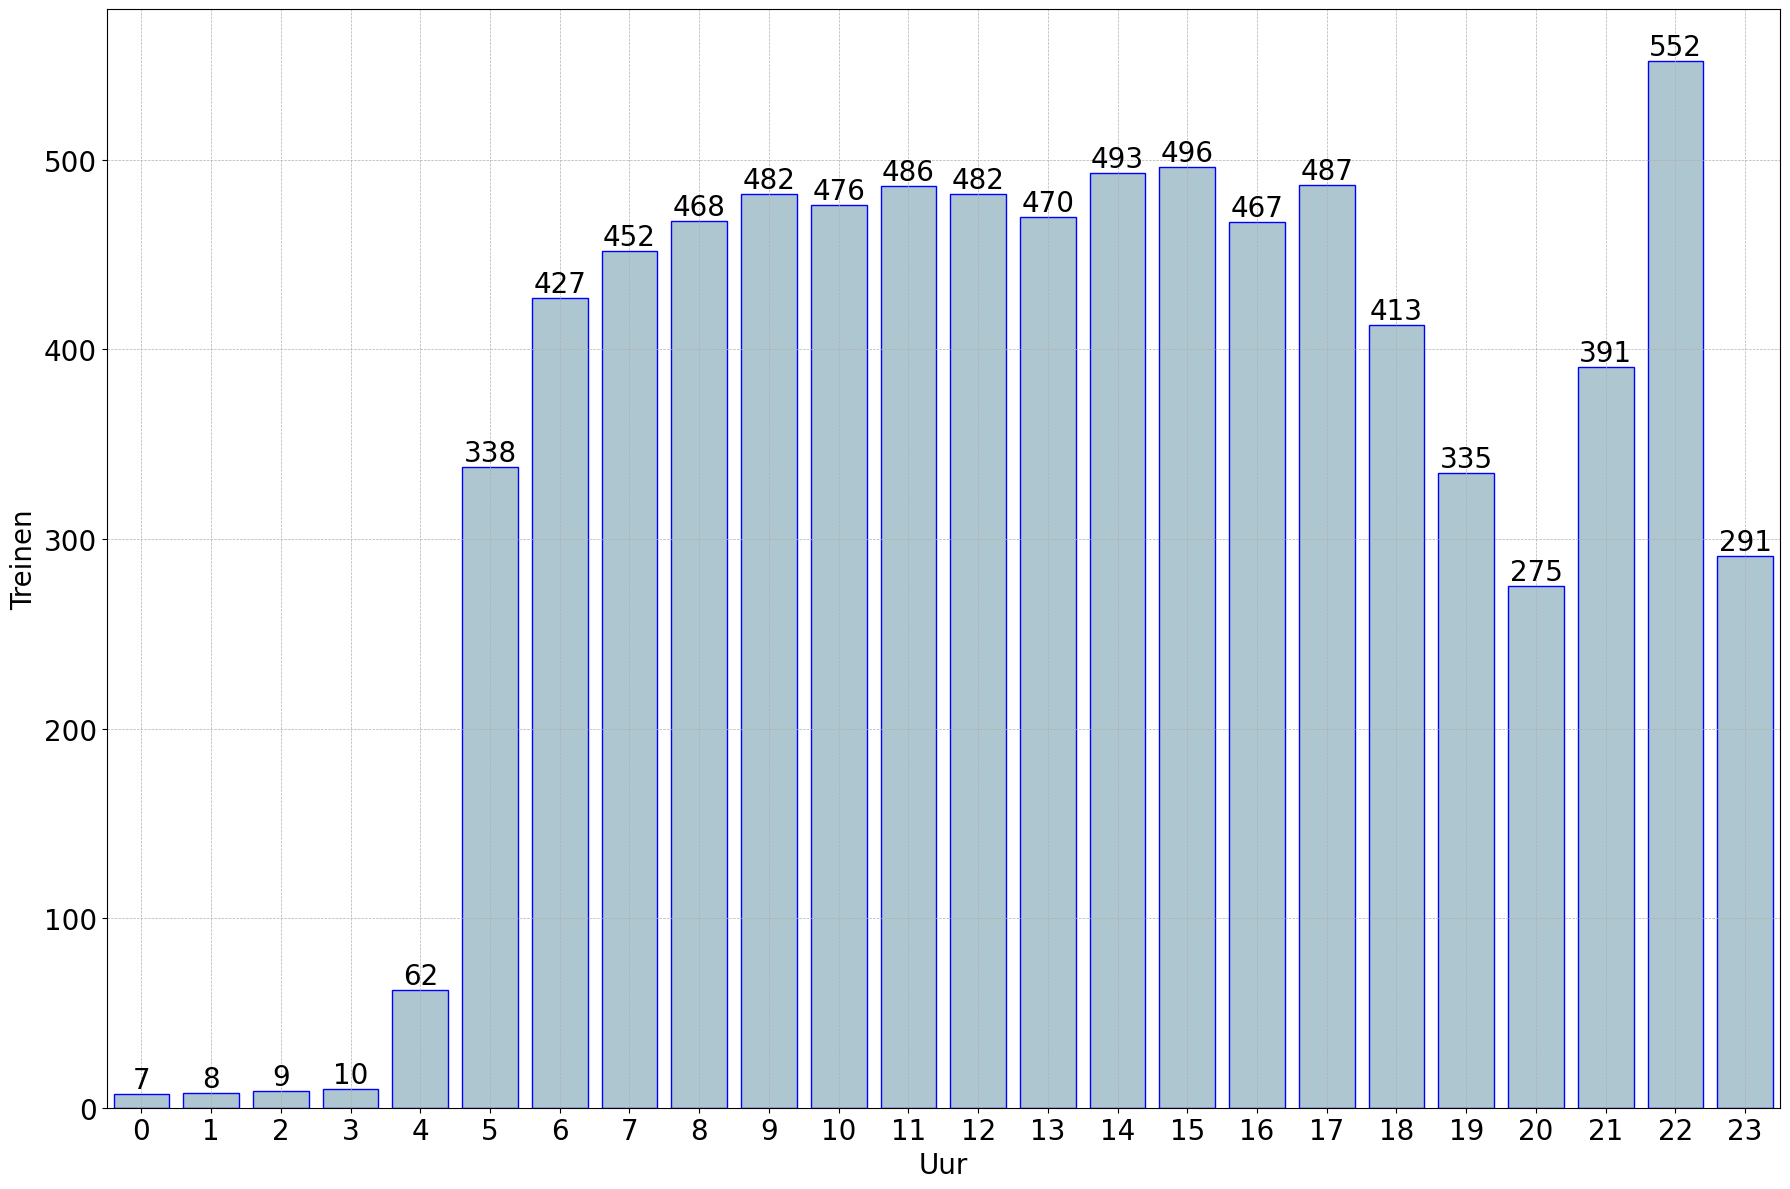

In [36]:
# Prepare dataset 

# Count the number of arriving trains per hour group
grouped_trains_schiphol = df_trains_schiphol.groupby('hour_group').size().reset_index().rename(columns={0: 'counts'})

plt.figure(figsize=(18,12))
ax = sns.barplot(data=grouped_trains_schiphol, x='hour_group', y='counts', color='blue', edgecolor='blue', facecolor='#AEC6CF')

# Display number of arriving trains at schphol per hour
for bar in ax.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), int(bar.get_height()), ha='center', va='bottom', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Uur', fontsize=20)
plt.ylabel('Treinen', fontsize=20)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('Schiphol_treinen.png', dpi=300)
plt.tight_layout()  # Adjust layout for better view
plt.show()

In [37]:
# df_trains_schiphol[df_trains_schiphol['Date'] == '2021-07-21']

### Combine histograms of disrupted trains and departured planes

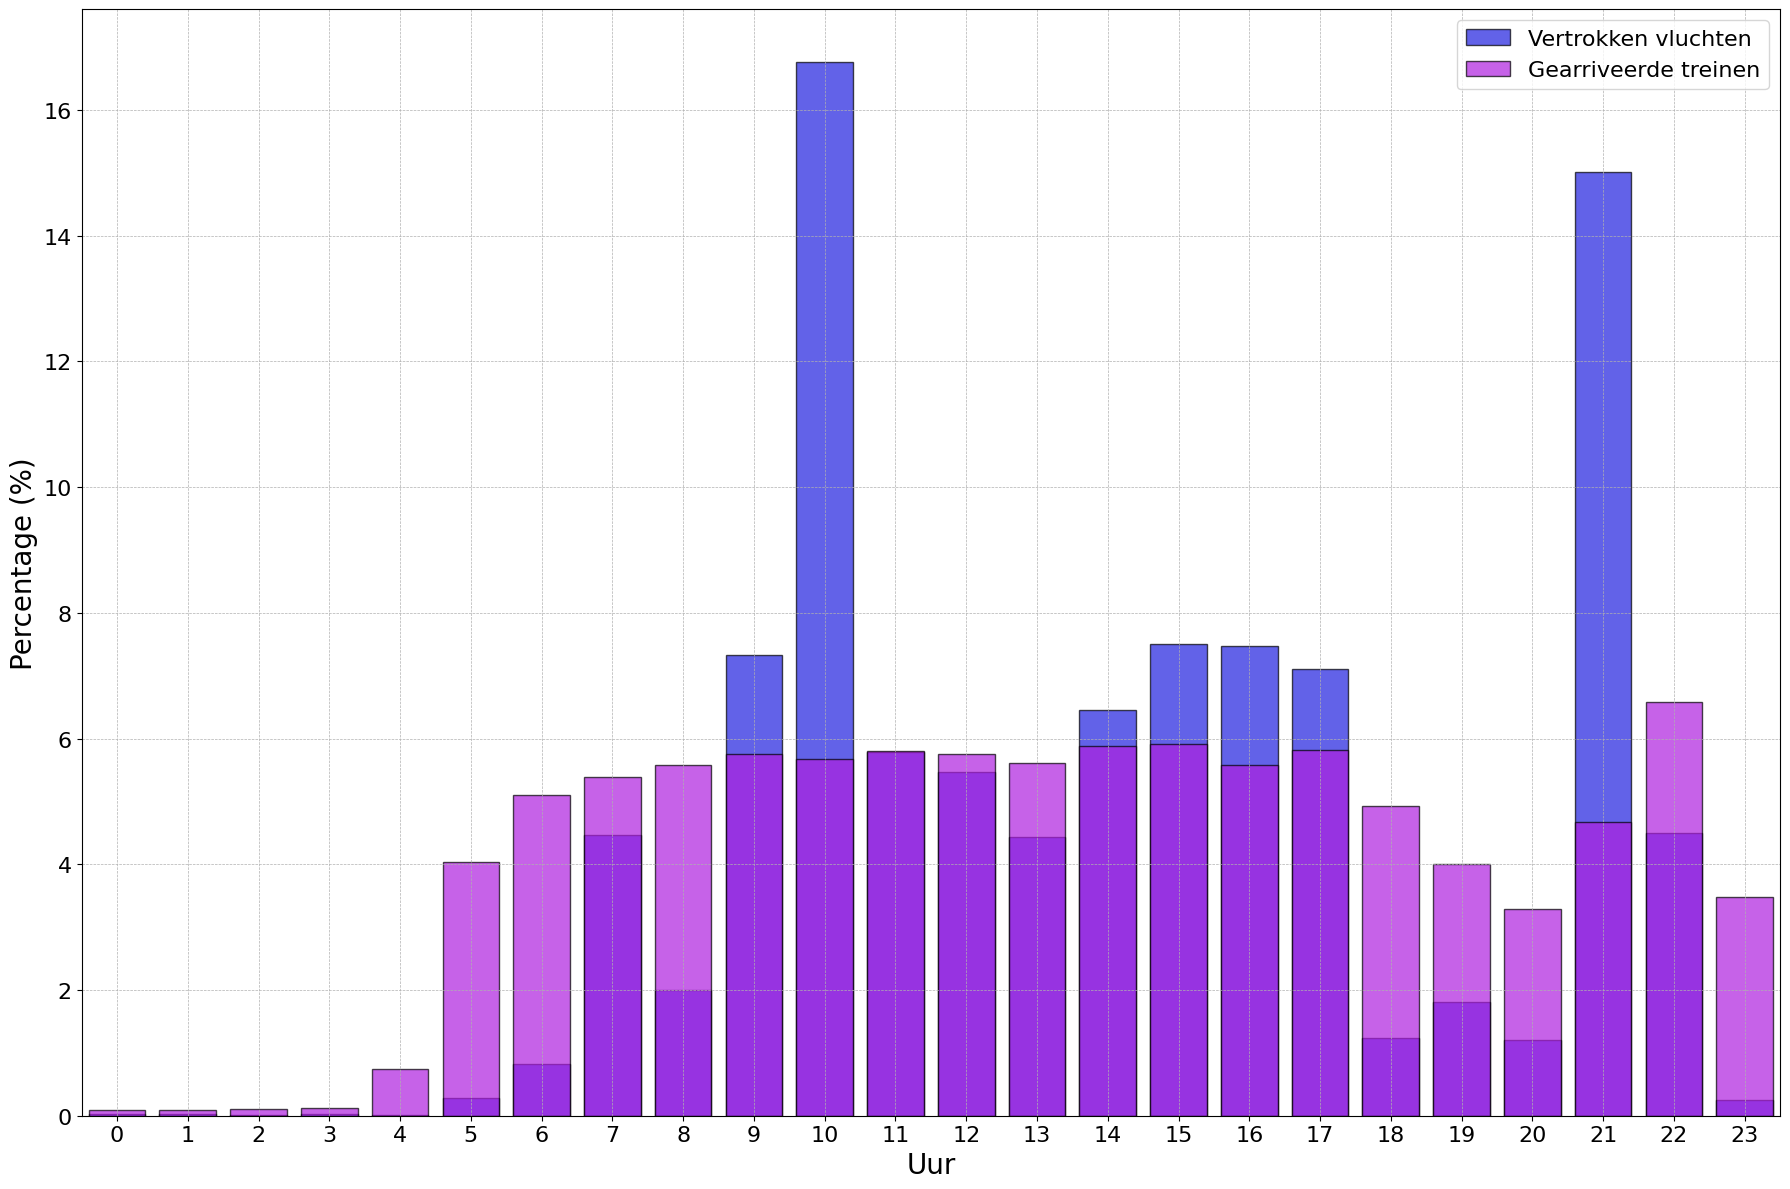

In [38]:
# Prepare datasets
grouped_departing_flights = df_flights_departure.groupby('hour_group').size().reset_index().rename(columns={0: 'counts'})
grouped_trains_schiphol = df_trains_schiphol.groupby('hour_group').size().reset_index().rename(columns={0: 'counts'})

# Normalize the data by converting counts to percentages
total_departing_flights = grouped_departing_flights['counts'].sum()
total_trains_schiphol = grouped_trains_schiphol['counts'].sum()

grouped_departing_flights['counts'] = (grouped_departing_flights['counts'] / total_departing_flights) * 100
grouped_trains_schiphol['counts'] = (grouped_trains_schiphol['counts'] / total_trains_schiphol) * 100

# Create a single plot
plt.figure(figsize=(18, 12))

# Plot normalized departing flights
# sns.barplot(data=grouped_departing_flights, x='hour_group', y='counts', color='blue', edgecolor='blue', facecolor='#AEC6CF', label='Departing Flights', alpha=0.7)

# # Plot normalized arriving trains
# sns.barplot(data=grouped_trains_schiphol, x='hour_group', y='counts', color='purple', edgecolor='purple', facecolor='purple', label='Arriving Trains', alpha=0.7)
# Plot departing flights

sns.barplot(data=grouped_departing_flights, x='hour_group', y='counts', 
            color='blue', edgecolor='black', label='Vertrokken vluchten', alpha=0.7)

# Plot arriving trains with contrasting purple
sns.barplot(data=grouped_trains_schiphol, x='hour_group', y='counts', 
            color='#BF00FF', edgecolor='black', label='Gearriveerde treinen', alpha=0.7)



# # Add text labels to each bar (for both datasets)
# for container in plt.gca().containers:
#     plt.bar_label(container, label_type='center', fontsize=14)

# Customize plot appearance
plt.xlabel('Uur', fontsize=20)
plt.ylabel('Percentage (%)', fontsize=20)
#plt.title('Verdeling van vertrekkende vluchten en arriverende treinen per uur op Schiphol.', fontsize=24)
plt.legend(fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save and show the plot
plt.tight_layout()
plt.savefig('Normalized_Flights_And_Trains.png', dpi=300, bbox_inches="tight")
plt.show()

#### Histogram of train routes 

In [39]:
# Unique train tracks to Schiphol
print(df_trains_schiphol['route_long_name'].unique())

# Numerical encoding of train tracks to Schiphol
label_encoder = LabelEncoder()

# Fit and transform the train tracks
df_trains_schiphol.loc[:,'route_group'] = label_encoder.fit_transform(df_trains_schiphol['route_long_name'])

# Dictionary with track names and encoding
dict_encoding_tracks = {index: label for index, label in enumerate(label_encoder.classes_)}

['Schiphol Airport <-> Venlo IC3500'
 'Schiphol Airport <-> Nijmegen IC3100'
 'Den Haag Centraal <-> Groningen IC700'
 'Schiphol Airport <-> Amersfoort Schothorst IC11600'
 'Den Haag Centraal <-> Leeuwarden IC1800' nan
 'Schiphol Airport <-> Enschede IC1600'
 'Den Haag Centraal <-> Amsterdam Centraal SPR4600'
 'Nachtnettrein Utrecht Centraal <-> Rotterdam Centraal'
 'Venlo <-> Dordrecht IC3700'
 'Amsterdam Centraal <-> Almere Centrum IC2600'
 'Nachtnettrein Amsterdam Bijlmer ArenA <-> Leiden Centraal'
 'Rotterdam Centraal <-> Arnhem Centraal IC3200'
 'Groningen <-> Amsterdam Centraal IC12600'
 'Lelystad Centrum <-> Dordrecht IC2400']


/var/folders/sh/90yjgzpn6435lg4k792260jw0000gn/T/ipykernel_44447/1669203476.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trains_schiphol.loc[:,'route_group'] = label_encoder.fit_transform(df_trains_schiphol['route_long_name'])


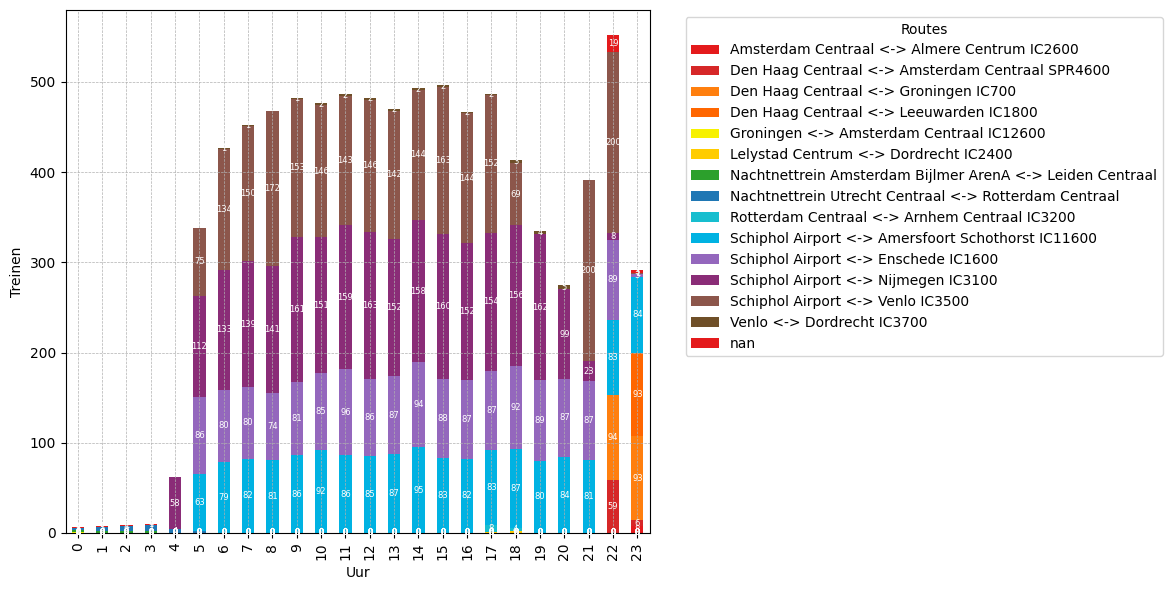

In [40]:
# Group the number of trains per hour group and route group
grouped_trains_schiphol = df_trains_schiphol.groupby(['hour_group', 'route_group']).size().unstack(fill_value=0)

# Color palette with contrasting colors 
num_route_groups = grouped_trains_schiphol.shape[1]  # Unique route groups
#color_palette = sns.color_palette("tab20", num_route_groups)  # 'tab20' alternative for high contrsting colors
custom_palette = sns.color_palette([
    "#e41a1c", "#d62728",  # Red, Dark Red
    "#ff7f0e", "#ff6600",  # Orange, Dark Orange
    "#f7f100", "#ffcc00",  # Yellow, Dark Yellow
    "#2ca02c", "#1f77b4",  # Light Green, Dark Green
    "#17becf", "#00b2e2",  # Cyan, Dark Cyan
    "#9467bd", "#8a2c77",  # Purple, Dark Purple
    "#8c564b", "#6f4f28"   # Brown, Dark Brown
])

# Display route groups per hour stacked on top of each other
ax = grouped_trains_schiphol.plot(kind='bar', stacked=True, figsize=(12, 6), color=custom_palette)
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=6, color='white') 

# Plot axes
plt.xlabel('Uur')
plt.ylabel('Treinen')
#plt.title('Number of Trains Arriving at Schiphol by Route Group')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(labels=dict_encoding_tracks.values(), title='Routes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()  
plt.savefig('Schiphol_treinen_stacked.png', dpi=300, bbox_inches="tight")
plt.show()


#### Histogram of proportion trains Schiphol dalayed/on time

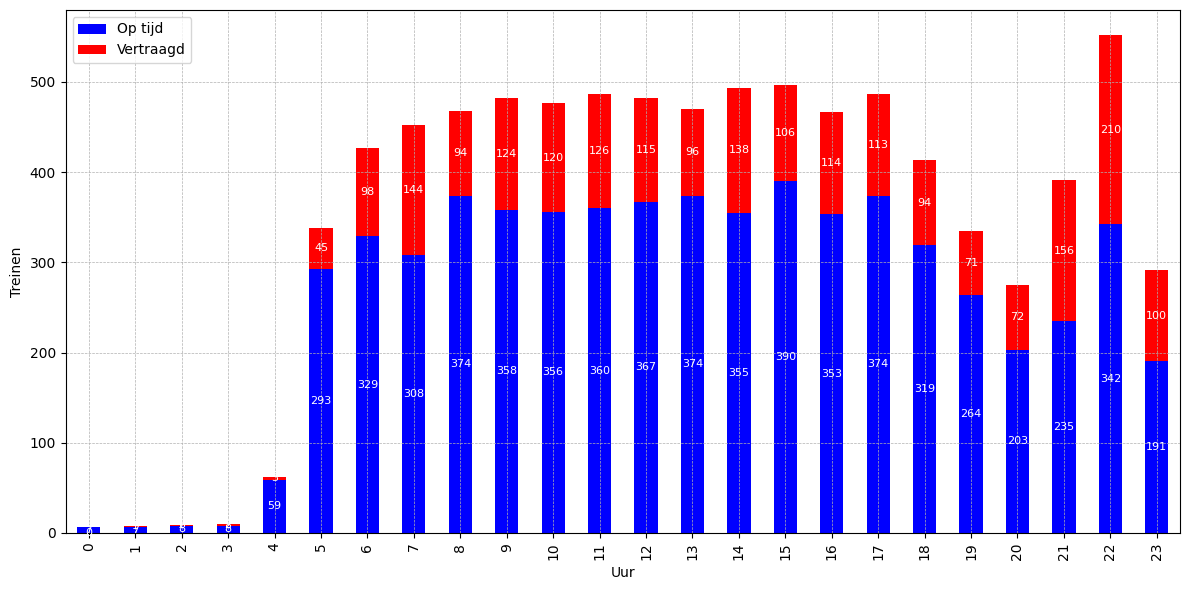

In [41]:
# Group the number of trains per hour group and route group
grouped_trains_delayed_schiphol = df_trains_schiphol.groupby(['hour_group', 'delay_indicator']).size().unstack(fill_value=0)

# Color palette with contrasting colors 
num_route_groups = grouped_trains_delayed_schiphol.shape[1] 
#color_palette = sns.color_palette("tab20", num_route_groups)  
custom_palette = sns.color_palette([
    "blue", "red",  # Red, Dark Red
])

# Plot the groups of delayed and on time
ax = grouped_trains_delayed_schiphol.plot(kind='bar', stacked=True, figsize=(12, 6), color=custom_palette)

for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=8, color='white')

# Plot axes
plt.xlabel('Uur')
plt.ylabel('Treinen')
#plt.title('Verdeling van arriverende treinen op Schiphol met/zonder vertraging.')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

#plt.legend(labels=['Op tijd', 'Vertraagd'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend(labels=['Op tijd', 'Vertraagd'], bbox_to_anchor=(0, 1), loc='upper left')

plt.tight_layout() 
plt.savefig('Schiphol_treinen_stacked.png', dpi=300, bbox_inches="tight")
plt.show()
